In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [29]:
np.random.seed(42)
datasets = f'../data/connectomes/'
connectomes = sorted(os.listdir(datasets)) 
print(connectomes)

# Ensure the necessary directories exist
os.makedirs('../images/imgs_connectomes_spectra_kde/', exist_ok=True)

['c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [30]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   # TODO: improve the estimation of d
   # d=0

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


In [31]:
def analyze_connectome_spectrum(connectome_filename, n_simulations=1, warm_up=1000, n_iteration=100, patience=10, d=0):
    """
    Analyze a single connectome file and save eigenvalues for real and simulated graphs.
    """
    # Read and process the graph
    real_graph = nx.read_graphml(datasets + connectome_filename)
    real_graph = nx.to_numpy_array(real_graph)
    
    # Get the logit graph results for initial parameters
    logit_graph, sigma, _, _, _, _ = get_logit_graph(
        real_graph=nx.from_numpy_array(real_graph),
        d=d,
        warm_up=warm_up,
        n_iteration=n_iteration,
        patience=patience,
        dist_type='KL'
    )
    
    # Setup model selection
    n_runs_graphs = 5
    all_graphs_lg = [nx.from_numpy_array(logit_graph)]
    log_params = [sigma]
    
    selector = ms.GraphModelSelection(
        graph=nx.from_numpy_array(real_graph),
        log_graphs=all_graphs_lg,
        log_params=log_params,
        models=["ER", "WS", "GRG", "BA", "LG"],
        n_runs=n_runs_graphs,
        parameters=[
            {'lo': 0.01, 'hi': 1},  # ER
            {'lo': 0.01, 'hi': 1},  # WS k=8
            {'lo': 1, 'hi': 3},     # GRG
            {'lo': 1, 'hi': 5},     # BA
        ]
    )
    
    result = selector.select_model_avg_spectrum()
    result_dict = {item['model']: {'param': clean_and_convert(item['param'])} 
                  for item in result['estimates']}

    # Get eigenvalues of real graph using adjacency matrix directly
    real_graph_nx = nx.from_numpy_array(real_graph)
    real_eigenvalues = np.real(np.linalg.eigvals(real_graph))  # Use adjacency matrix
    
    # Save real eigenvalues
    real_data = {'eigenvalues': real_eigenvalues}
    
    # Generate multiple graphs for each model and save eigenvalues
    simulated_eigenvalues = {}
    
    for model in result_dict.keys():
        simulated_eigenvalues[model] = []
        
        for i in range(n_simulations):
            if model != 'LG':
                # Generate graph using appropriate model
                func = selector.model_function(model_name=model)
                G = func(real_graph.shape[0], float(result_dict[model]['param']))
                adj_matrix = nx.to_numpy_array(G)
            else:
                # Generate new logit graph for each simulation
                logit_graph, _, _, _, _, _ = get_logit_graph(
                    real_graph=nx.from_numpy_array(real_graph),
                    d=d,
                    warm_up=warm_up,
                    n_iteration=n_iteration,
                    patience=patience,
                    dist_type='KL'
                )
                #G = nx.from_numpy_array(logit_graph)
                adj_matrix = logit_graph
            
            # Calculate eigenvalues using adjacency matrix
            eigenvalues = np.real(np.linalg.eigvals(adj_matrix))  # Use adjacency matrix
            simulated_eigenvalues[model].append(eigenvalues)
        
    # Save results
    os.makedirs(f'runs/connectomes_spectra_kde/{connectome_filename}', exist_ok=True)
    with open(f'runs/connectomes_spectra_kde/{connectome_filename}/simulated_eigenvalues.pkl', 'wb') as f:
        pickle.dump(simulated_eigenvalues, f)
    with open(f'runs/connectomes_spectra_kde/{connectome_filename}/real_eigenvalues.pkl', 'wb') as f:
        pickle.dump(real_data, f)
    
    return real_data, simulated_eigenvalues

# simulation

In [32]:
# Good connectomes Previously fitted and had nice results
good_connectomes = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml',
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]
for connectome_file in good_connectomes:
    real_graph = nx.read_graphml(datasets + connectome_file)
    real_graph = nx.to_numpy_array(real_graph)
    print(f'Nodes: {real_graph.shape[0]} | {connectome_file}')

#connectome_file = 'rhesus_brain_2.graphml'
connecotme_file = 'p.pacificus_neural.synaptic_2.graphml'

Nodes: 272 | c.elegans_neural.male_1.graphml
Nodes: 213 | mouse_brain_1.graphml
Nodes: 195 | mouse_visual.cortex_2.graphml
Nodes: 50 | p.pacificus_neural.synaptic_2.graphml
Nodes: 91 | rhesus_brain_2.graphml


In [63]:
# ----- Simulation Section -----
warm_up = 5000
n_iteration = 5000
patience = 10
n_simulations = 10  # For estimation the confidence intervals
simulation_results = []
n_connectomes = 1 # dummy
d = 0 

In [64]:
real_graph = nx.read_graphml(datasets + connectome_file)
logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
    real_graph=real_graph,
    d=d,
    warm_up=warm_up,
    n_iteration=n_iteration,
    patience=patience,
    dist_type='KL'
)
sim_graphs_dict = {
    'Real': real_graph,
    'Logit': nx.from_numpy_array(logit_graph)
}
result_dict = {
    'Real': {'GIC': 0},
    'Logit': {'GIC': gic_values[0]}
}

                          Results: Logit
Model:              Logit            Method:           MLE        
Dependent Variable: y                Pseudo R-squared: 0.150      
Date:               2025-03-23 18:30 AIC:              2853.3877  
No. Observations:   4095             BIC:              2872.3403  
Df Model:           2                Log-Likelihood:   -1423.7    
Df Residuals:       4092             LL-Null:          -1674.0    
Converged:          1.0000           LLR p-value:      1.8844e-109
No. Iterations:     16.0000          Scale:            1.0000     
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -5.3957     0.2319   -23.2718   0.0000   -5.8502   -4.9413
x1         0.1465     0.0207     7.0691   0.0000    0.1059    0.1871
x2         0.3505     0.0190    18.4363   0.0000    0.3132    0.3878

iteratio

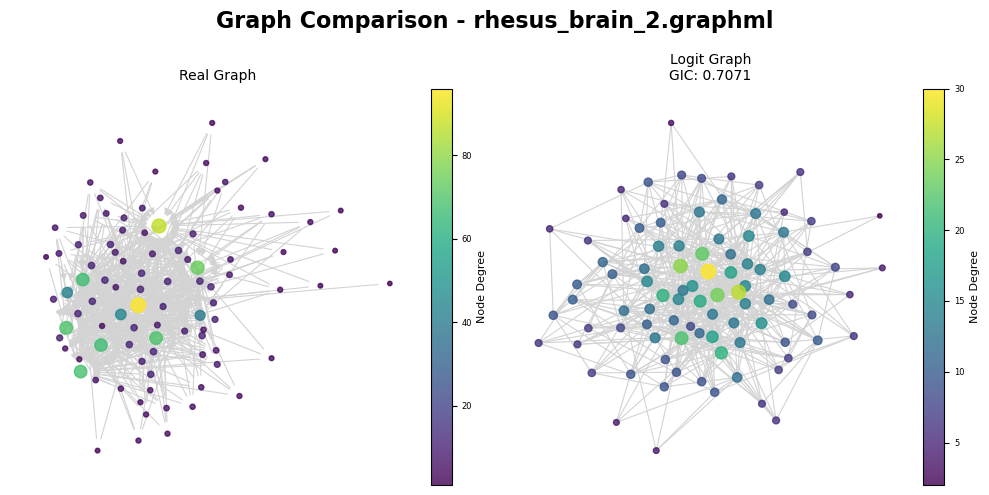

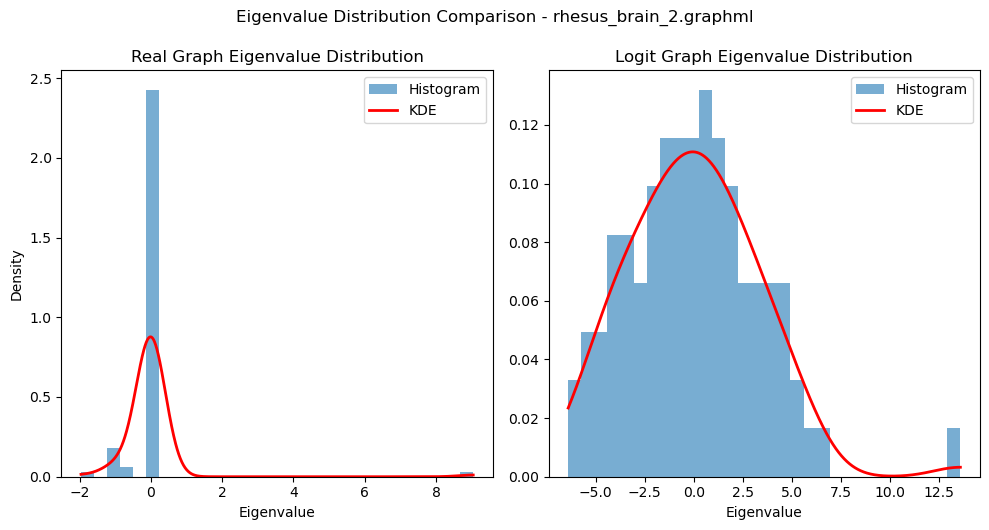

In [65]:
# Single connectome viz
fig = plot_graphs_in_matrix(
    sim_graphs_dict, 
    result_dict, 
    global_title=f'Graph Comparison - {connectome_file}',
    save_path=f'../images/imgs_connectomes_spectra_kde/graph_comparison_{connectome_file}.png'
)
plt.show()

# Compare eigenvalue distributions with KDE
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Get eigenvalues for both graphs
real_adj = nx.to_numpy_array(real_graph)
real_eigenvalues = np.linalg.eigvals(real_adj).real
logit_eigenvalues = np.linalg.eigvals(logit_graph).real

# Plot for Real graph
axes[0].hist(real_eigenvalues, bins=30, alpha=0.6, density=True, label='Histogram')
real_kde = gaussian_kde(real_eigenvalues)
x_range = np.linspace(min(real_eigenvalues), max(real_eigenvalues), 1000)
axes[0].plot(x_range, real_kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0].set_title('Real Graph Eigenvalue Distribution')
axes[0].set_xlabel('Eigenvalue')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot for Logit graph
axes[1].hist(logit_eigenvalues, bins=30, alpha=0.6, density=True, label='Histogram')
logit_kde = gaussian_kde(logit_eigenvalues)
x_range = np.linspace(min(logit_eigenvalues), max(logit_eigenvalues), 1000)
axes[1].plot(x_range, logit_kde(x_range), 'r-', linewidth=2, label='KDE')
axes[1].set_title('Logit Graph Eigenvalue Distribution')
axes[1].set_xlabel('Eigenvalue')
axes[1].legend()

plt.tight_layout()
plt.suptitle(f'Eigenvalue Distribution Comparison - {connectome_file}', y=1.05)
plt.savefig(f'../images/imgs_connectomes_spectra_kde/eigenvalue_kde_{connectome_file}.png', bbox_inches='tight')
plt.show()

In [ ]:
# FULL SIMULATION
real_data_eigen, simulated_eigenvalues = analyze_connectome_spectrum(connectome_file, 
                                                                     n_simulations=n_simulations, 
                                                                     warm_up=warm_up, 
                                                                     n_iteration=n_iteration, 
                                                                     patience=patience, d=d)

                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: y                Pseudo R-squared: 0.701    
Date:               2025-03-23 18:30 AIC:              1006.4076
No. Observations:   4095             BIC:              1025.3602
Df Model:           2                Log-Likelihood:   -500.20  
Df Residuals:       4092             LL-Null:          -1674.0  
Converged:          1.0000           LLR p-value:      0.0000   
No. Iterations:     18.0000          Scale:            1.0000   
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const   -6.7392     0.2587   -26.0513   0.0000   -7.2462   -6.2322
x1       0.1073     0.0045    23.9273   0.0000    0.0985    0.1161
x2       0.1274     0.0057    22.1926   0.0000    0.1161    0.1386

iteration: 0
	 Spectrum difference: 2

In [58]:
def plot_spectrum_comparison(real_data, simulated_eigenvalues, title, save_path=None, figsize=(15, 10), xlim=None, ylim=None, log_scale=False):
    """
    Plot KDE comparison of eigenvalue spectra with confidence intervals.
    
    Args:
        real_data (dict): Contains eigenvalues for real graph
        simulated_eigenvalues (dict): Contains eigenvalues for each model
        title (str): Plot title
        save_path (str): Path to save the figure
        figsize (tuple): Figure size (width, height)
        xlim (tuple): Optional x-axis limits as (min, max)
        ylim (tuple): Optional y-axis limits as (min, max)
        log_scale (bool): Whether to use log scale for y-axis
    """
    # Color scheme for different models
    colors = {
        'Real': '#1f77b4',    # Blue
        'LG': '#2ca02c',      # Green
        'ER': '#ff7f0e',      # Orange
        'BA': '#d62728',      # Red
        'WS': '#9467bd',      # Purple
        'GRG': '#8c564b'      # Brown
    }
    
    plt.figure(figsize=figsize)
    
    # Get real eigenvalues
    real_eigenvalues = real_data['eigenvalues']
    
    # Determine common x-range
    all_eigenvalues = [real_eigenvalues]
    for model_eigs in simulated_eigenvalues.values():
        all_eigenvalues.extend([eig for eig in model_eigs])
    
    if xlim is None:
        x_min = min([np.min(eig) for eig in all_eigenvalues])
        x_max = max([np.max(eig) for eig in all_eigenvalues])
    else:
        x_min, x_max = xlim
    x_range = np.linspace(x_min, x_max, 200)
    
    # Plot real data with small noise to avoid singular matrix
    real_eigenvalues_noisy = real_eigenvalues + np.random.normal(0, 1e-10, size=real_eigenvalues.shape)
    real_kde = gaussian_kde(real_eigenvalues_noisy)
    plt.plot(x_range, real_kde(x_range), 
            label='Real', 
            color=colors['Real'],
            linewidth=2)
    
    # Plot simulated data with confidence intervals
    for model, eigenvalues_list in simulated_eigenvalues.items():
        kde_curves = []
        
        # Calculate KDE for each simulation
        for eigenvalues in eigenvalues_list:
            # Add small noise to avoid singular matrix
            eigenvalues_noisy = eigenvalues + np.random.normal(0, 1e-10, size=eigenvalues.shape)
            kde = gaussian_kde(eigenvalues_noisy)
            kde_curves.append(kde(x_range))
        
        # Convert to numpy array for calculations
        kde_curves = np.array(kde_curves)
        
        # Calculate mean and confidence intervals
        mean_curve = np.mean(kde_curves, axis=0)
        lower_ci = np.percentile(kde_curves, 2.5, axis=0)
        upper_ci = np.percentile(kde_curves, 97.5, axis=0)
        
        # Plot mean curve
        plt.plot(x_range, mean_curve, 
                label=model, 
                color=colors.get(model, 'gray'),
                linewidth=2)
        
        # Plot confidence interval
        plt.fill_between(x_range, 
                        lower_ci, 
                        upper_ci,
                        alpha=0.2, 
                        color=colors.get(model, 'gray'))
    
    plt.title(f'Spectrum Analysis: {title}')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    if log_scale:
        plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)
        
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    # Add statistics
    stats_text = "Statistics:\n"
    stats_text += f"Real mean: {np.mean(real_eigenvalues):.3f}\n"
    stats_text += f"Real std: {np.std(real_eigenvalues):.3f}\n"
    
    for model, eigenvalues_list in simulated_eigenvalues.items():
        all_eigs = np.concatenate(eigenvalues_list)
        stats_text += f"\n{model} mean: {np.mean(all_eigs):.3f}\n"
        stats_text += f"{model} std: {np.std(all_eigs):.3f}"
    
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


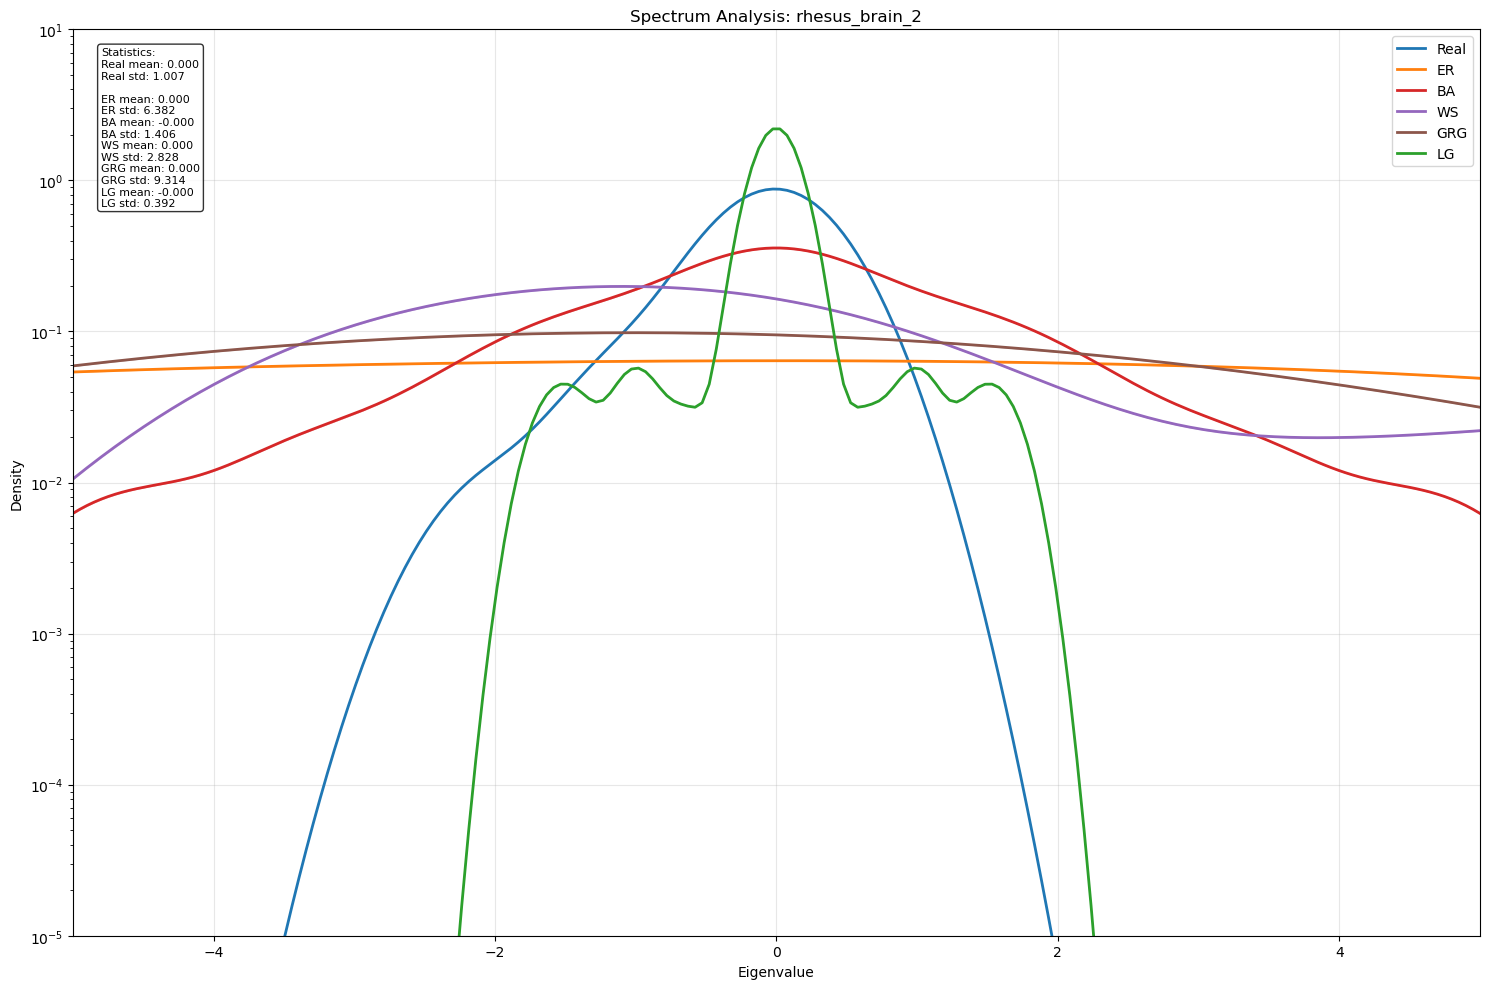

In [62]:
# Create the plot
plot_spectrum_comparison(
    real_data_eigen,
    simulated_eigenvalues,
    title=connectome_file.replace('.graphml', ''),
    save_path=f'../images/imgs_connectomes_spectra_kde/spectrum_comparison_{connectome_file}.png',
    xlim=(-5, 5), 
    ylim=(1e-5, 1e1),
    log_scale=True
)